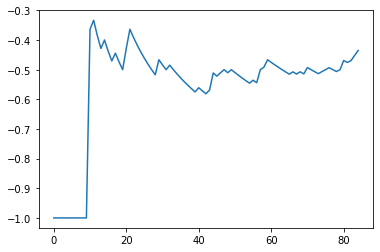

episode:  84 score: 1.00  average score -0.44  epsolon:  0.17283137059314588  memory size 4022
16/16 [==============================] - 0s 3ms/step
episode:  85 score: -1.00  average score -0.44  epsolon:  0.16949297932511645  memory size 4061
1/1 [==============================] - 0s 50ms/step


16/16 [==============================] - 0s 3ms/step


 1/16 [>.............................] - ETA: 0s

KeyboardInterrupt: 

In [1]:
import GameEnv
import pygame
import numpy as np
from ddqn_keras import DDQNAgent
from collections import deque
import random, math
import matplotlib.pyplot as plt
from IPython.display import clear_output

TOTAL_GAMETIME = 1000 # Max game time for one episode
N_EPISODES = 10000
REPLACE_TARGET = 50 

game = GameEnv.RacingEnv()
game.fps = 60

GameTime = 0 
GameHistory = []
renderFlag = False

ddqn_agent = DDQNAgent(alpha=0.010, gamma=0.5, n_actions=5, epsilon=1.00, epsilon_end=0.10, epsilon_dec=0.9995, replace_target= REPLACE_TARGET, batch_size=512, input_dims=19,fname='ddqn_model1.h5')

# if you want to load the existing model uncomment this line.
# careful an existing model might be overwritten
#ddqn_agent.load_model()

ddqn_scores = []
eps_history = []
avg_scores=[]

def run():

    for e in range(N_EPISODES):
        
        game.reset() #reset env 

        done = False
        score = 0
        counter = 0
        
        observation_, reward, done = game.step(0)
        observation = np.array(observation_)

        gtime = 0 # set game time back to 0
        
        renderFlag = False # if you want to render every episode set to true

        if e % 10 == 0 and e > 0: # render every 10 episodes
            renderFlag = True

        while not done:
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT: 
                    return

            action = ddqn_agent.choose_action(observation)
            observation_, reward, done = game.step(action)
            observation_ = np.array(observation_)

            # This is a countdown if no reward is collected the car will be done within 100 ticks
            if reward == 0:
                counter += 1
                if counter > 100:
                    done = True
            else:
                counter = 0

            score += reward

            ddqn_agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            ddqn_agent.learn()
            
            gtime += 1

            if gtime >= TOTAL_GAMETIME:
                done = True

            if renderFlag:
                game.render(action)

        eps_history.append(ddqn_agent.epsilon)
        ddqn_scores.append(score)
        avg_score = np.mean(ddqn_scores[max(0, e-100):(e+1)])
        avg_scores.append(avg_score)

        if e % REPLACE_TARGET == 0 and e > REPLACE_TARGET:
            ddqn_agent.update_network_parameters()

        if e % 10 == 0 and e > 10:
            ddqn_agent.save_model()
            print("save model")
#         plt.clf()
#         plt.plot(ddqn_scores)
#         plt.draw()
#         plt.pause(0.001)
        if e % 2 == 0:
            clear_output(wait=True)
            plt.plot(avg_scores)
            plt.pause(0.05)
            plt.show()
            


        
        print('episode: ', e,'score: %.2f' % score,
              ' average score %.2f' % avg_score,
              ' epsolon: ', ddqn_agent.epsilon,
              ' memory size', ddqn_agent.memory.mem_cntr % ddqn_agent.memory.mem_size)
        

run()